In [1]:
import gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import time
from gym import spaces

C:\ProgramData\Miniconda3\lib\site-packages\flatbuffers\compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
C:\ProgramData\Miniconda3\lib\site-packages\keras\utils\image_utils.py:36: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
C:\ProgramData\Miniconda3\lib\site-packages\keras\utils\image_utils.py:37: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
C:\ProgramData\Miniconda3\lib\site-packages\keras\utils\image_utils.py:38: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  'bicubic': pil_image.BICUBIC,
C:\ProgramData\Miniconda3\lib\site-packages\keras\utils\image_utils.py:39: DeprecationWar

In [2]:
# Set seed
seed = 1453

# https://www.gymlibrary.ml/environments/box2d/lunar_lander/
env = gym.make('LunarLander-v2',
              continuous=True)

# env = gym.make(
#     "LunarLander-v2",
#     continuous=False,
#     gravity=-10.0,
#     enable_wind=False,
#     wind_power=15.0,
#     turbulence_power=1.5,
# )

# This is needed to get the input size for the NN
num_states = env.observation_space.low.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

# Normalize action space according to https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
action_space = spaces.Box(low=-1, high=1, shape=(num_actions,), dtype='float32')

# This is needed to clip the actions within the legal boundaries
upper_bound = action_space.high[0]
lower_bound = action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  8
Size of Action Space ->  2
Max Value of Action ->  1.0
Min Value of Action ->  -1.0


C:\ProgramData\Miniconda3\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


In [3]:
# Using OU Noise
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [4]:
def get_actor(layer1=400, layer2=300):
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(layer1, activation="relu")(inputs)
    out = layers.Dense(layer2, activation="relu")(out)
    # Must have output size of 2
    outputs = layers.Dense(num_actions, activation="tanh", kernel_initializer=last_init)(out)

    # Multiply to fill the whole action space which should be equal around 0
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model

def get_critic(layer1=400, layer2=300):
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(layer1, activation="relu")(concat)
    out = layers.Dense(layer2, activation="relu")(out)
    # Also requires output size of 2 here
    outputs = layers.Dense(num_actions)(out)

    # Make it into a keras model
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

# This updates the weights in a slow manner which keeps stability
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

In [5]:
class Agent:
    def __init__(self, buffer_capacity=50000, batch_size=64, std_dev=0.2, critic_lr=0.002,
            actor_lr=0.001, gamma=0.99, tau=0.005):
        
        self.buffer_capacity = buffer_capacity
        self.batch_size = batch_size

        # This is used to make sure we only sample from used buffer space
        self.buffer_counter = 0

        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))
        
        self.std_dev = std_dev
        self.critic_lr = critic_lr
        self.actor_lr = actor_lr
        self.gamma = gamma
        self.tau = tau
        
        self.actor_model = get_actor(layer1=400, layer2=300)
        self.critic_model = get_critic(layer1=400, layer2=300)

        self.target_actor = get_actor(layer1=400, layer2=300)
        self.target_critic = get_critic(layer1=400, layer2=300)
        
        self.critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
        self.actor_optimizer = tf.keras.optimizers.Adam(actor_lr)
        
        # Making the weights equal initially
        self.target_actor.set_weights(self.actor_model.get_weights())
        self.target_critic.set_weights(self.critic_model.get_weights())
        
        self.ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))
    
    # Makes a record of the outputted (s,a,r,s') obervation tuple
    def record(self, obs_tuple):
        # Reuse the same buffer replacing old entries
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1
    
    # Move the update and learn function from buffer to Agent to "decrease" scope
    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        with tf.GradientTape() as tape:
            target_actions = self.target_actor(next_state_batch, training=True)
            y = reward_batch + self.gamma * self.target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = self.critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, self.critic_model.trainable_variables)
        self.critic_optimizer.apply_gradients(
            zip(critic_grad, self.critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = self.actor_model(state_batch, training=True)
            critic_value = self.critic_model([state_batch, actions], training=True)

            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, self.actor_model.trainable_variables)
        self.actor_optimizer.apply_gradients(
            zip(actor_grad, self.actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Sample only valid data
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)
        
    def policy(self, state, noise_object, use_noise=True, noise_mult=1):
        # For doing actions without added noise
        if not use_noise:     
            sampled_actions = tf.squeeze(self.actor_model(state)).numpy()
            legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

            return [np.squeeze(legal_action)]
        else:
            sampled_actions = tf.squeeze(self.actor_model(state))
            noise = noise_object()
            # Adding noise to action
            sampled_actions = sampled_actions.numpy() + noise * noise_mult

            # We make sure action is within bounds
            legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

            return [np.squeeze(legal_action)]

In [6]:
def fixed(x, episode):
    return x

In [16]:
def run(total_trials=3, total_episodes=100, 
            buffer_capacity=50000, batch_size=64, std_dev=0.2, critic_lr=0.002, render=False,
            actor_lr=0.001, gamma=0.99, tau=0.005, noise_mult=1, save_weights=False, 
            directory='Weights/', actor_name='actor', critic_name='critic',
            gamma_func=fixed, tau_func=fixed, critic_lr_func=fixed, actor_lr_func=fixed,
            noise_mult_func=fixed, std_dev_func=fixed, mean_number=40, output=True,
            return_rewards=False, total_time=True, use_guide=False):
    tot_time = time.time()
    # To store reward history of each episode
    ep_reward_list = []
    # To store average reward history of last few episodes
    avg_reward_list = []
    # To separate assisted reward structures from the "true"
    true_reward_list = []
    true_avg_reward_list = []
    
    for trial in range(total_trials):

        # add sublists for each trial
        avg_reward_list.append([])
        ep_reward_list.append([])
        
        true_reward_list.append([])
        true_avg_reward_list.append([])
        
        agent = Agent(buffer_capacity=buffer_capacity, batch_size=batch_size, std_dev=std_dev, 
                critic_lr=critic_lr, actor_lr=actor_lr, gamma=gamma, tau=tau)

        for ep in range(total_episodes):
            # functions for different parameters
            agent.gamma = gamma_func(gamma, ep)
            agent.tau = tau_func(tau, ep)
            agent.critic_lr = critic_lr_func(critic_lr, ep)
            agent.actor_lr = actor_lr_func(actor_lr, ep)
            agent.noise_mult = noise_mult_func(noise_mult, ep)
            agent.std_dev = std_dev_func(std_dev, ep)
            
            # Used for time benchmarking
            before = time.time()

            prev_state = env.reset()
            episodic_reward = 0
            true_reward = 0

            while True:
                if render:
                    env.render()
                
                tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

                action = agent.policy(tf_prev_state, agent.ou_noise, noise_mult=noise_mult)
                
                # To get the right format
                action = action[0]
                
                # Recieve state and reward from environment.
                state, reward, done, info = env.step(action)
                
                # Add this before eventual reward modification
                true_reward += reward
                
                # Reward modification
                if use_guide:
                    # giving penalty for straying far from flags and having high speed
                    # x max
#                     reward -= int(abs(state[0]) > 0.15) * 2 * abs(state[0])
#                     # y top
#                     reward -= int(state[1] > 1) * state[1] / 2
#                     # horizontal speed
#                     reward -= int(abs(state[2]) > 1) * abs(state[2])
#                     # down speed
#                     reward -= int(state[3] <  -1) * abs(state[3])
#                     # up speed
#                     reward -= int(state[3] > 0.1) * 3 * state[3]
                    reward += (abs(state[0])+0.2) * (abs(state[1])+0.2)

                agent.record((prev_state, action, reward, state))
                episodic_reward += reward

                agent.learn()
                update_target(agent.target_actor.variables, agent.actor_model.variables, agent.tau)
                update_target(agent.target_critic.variables, agent.critic_model.variables, agent.tau)

                # End this episode if en episode is done
                if done:
                    break

                prev_state = state

            ep_reward_list[trial].append(episodic_reward)
            
            true_reward_list[trial].append(true_reward)
            
            true_avg_reward = np.mean(true_reward_list[trial][-mean_number:])
            true_avg_reward_list[trial].append(true_avg_reward)

            # Mean of last x episodes
            avg_reward = np.mean(ep_reward_list[trial][-mean_number:])
            if output:
                print("Episode {} * Avg Reward {:.2f} * true_avg_reward {:.2f} * reward {:.2f} * true_reward {:.2f} * time used: {:.2f}"
                  .format(ep, avg_reward, true_avg_reward, episodic_reward, true_reward, (time.time() - before)))
            avg_reward_list[trial].append(avg_reward)

        if save_weights:
            agent.actor_model.save_weights(directory + actor_name + '-trial' + str(trial) + '.h5')
            agent.critic_model.save_weights(directory + critic_name + '-trial' + str(trial) + '.h5')
    
    # Plotting graph
    for idx, p in enumerate(true_avg_reward_list):
        plt.plot(p, label=str(idx))
    plt.xlabel("Episode")
    plt.ylabel("True Avg. Epsiodic Reward (" + str(mean_number) + ")")
    plt.legend()
    plt.show()
    
    print('total time:',time.time() - tot_time, 's')
    
    # Return to be able to make graphs etc. later, or use the data for other stuff
    if return_rewards:
        return true_reward_list

In [17]:
def test(total_episodes=10, actor_weights='Weights/actor-trial0.h5', render=False):
    rewards = []
    
    for ep in range(total_episodes):
        ep_reward = 0
        
        # Used for time benchmarking
        before = time.time()
        
        prev_state = env.reset()
        agent = Agent(buffer_capacity=0, batch_size=0, std_dev=0, 
                critic_lr=0, actor_lr=0, gamma=0, tau=0)
        agent.actor_model.load_weights(actor_weights)
        
        while True:
            if render:
                env.render()

            tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

            action = agent.policy(tf_prev_state, 0, use_noise=False)
            action = action[0]
            state, reward, done, _ = env.step(action)
            
            print(state)
            
            ep_reward += reward

            if done:
                print(str(time.time() - before) + 's')
                rewards.append(ep_reward)
                break

            prev_state = state
            
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("True reward")
    plt.show()

In [18]:
def random(total_episodes=10, render=False):
    rewards = []
    
    for ep in range(total_episodes):
        ep_reward = 0
        
        # Used for time benchmarking
        before = time.time()
        
        prev_state = env.reset()
        
        while True:
            if render:
                env.render()
            action = action_space.sample()
            
            state, reward, done, _ = env.step(action)
            
            ep_reward += reward

            if done:
                print(str(time.time() - before) + 's')
                rewards.append(ep_reward)
                break

            prev_state = state
            
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("True reward")
    plt.show()

---
# Runs and tests
---

In [19]:
def a(x, episode):
    if episode < 100:
        return 1
    elif episode < 200:
        return 0.7
    elif episode < 300:
        return 0.2
    else:
        return 0.4

In [20]:
def b(x, episode):
    if episode < 200:
        return 0.015
    else:
        return 0.005

Episode 0 * Avg Reward -1073.84 * true_avg_reward -1000.70 * reward -1073.84 * true_reward -1000.70 * time used: 1.40
Episode 1 * Avg Reward -1027.18 * true_avg_reward -942.09 * reward -980.52 * true_reward -883.49 * time used: 0.54
Episode 2 * Avg Reward -936.73 * true_avg_reward -869.07 * reward -755.83 * true_reward -723.02 * time used: 0.55
Episode 3 * Avg Reward -838.57 * true_avg_reward -743.88 * reward -544.09 * true_reward -368.32 * time used: 0.93
Episode 4 * Avg Reward -752.76 * true_avg_reward -660.92 * reward -409.52 * true_reward -329.05 * time used: 0.66
Episode 5 * Avg Reward -694.47 * true_avg_reward -598.79 * reward -403.01 * true_reward -288.15 * time used: 0.67
Episode 6 * Avg Reward -649.95 * true_avg_reward -558.51 * reward -382.87 * true_reward -316.81 * time used: 0.75
Episode 7 * Avg Reward -580.17 * true_avg_reward -495.98 * reward -91.67 * true_reward -58.29 * time used: 0.64
Episode 8 * Avg Reward -593.79 * true_avg_reward -503.86 * reward -702.73 * true_rewa

Episode 72 * Avg Reward -685.78 * true_avg_reward -630.06 * reward -753.71 * true_reward -695.11 * time used: 0.87
Episode 73 * Avg Reward -694.10 * true_avg_reward -636.53 * reward -748.17 * true_reward -656.32 * time used: 0.59
Episode 74 * Avg Reward -702.49 * true_avg_reward -644.40 * reward -773.93 * true_reward -737.00 * time used: 0.75
Episode 75 * Avg Reward -705.61 * true_avg_reward -646.33 * reward -578.87 * true_reward -516.15 * time used: 0.59
Episode 76 * Avg Reward -714.69 * true_avg_reward -655.38 * reward -644.65 * true_reward -616.61 * time used: 0.62
Episode 77 * Avg Reward -724.85 * true_avg_reward -664.07 * reward -1005.59 * true_reward -918.50 * time used: 0.72
Episode 78 * Avg Reward -727.20 * true_avg_reward -665.81 * reward -508.85 * true_reward -468.01 * time used: 0.63
Episode 79 * Avg Reward -731.94 * true_avg_reward -668.85 * reward -609.27 * true_reward -521.31 * time used: 0.82
Episode 80 * Avg Reward -729.79 * true_avg_reward -666.10 * reward -525.14 * tr

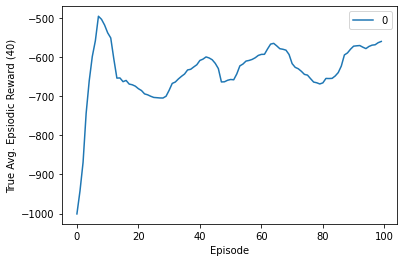

total time: 67.09088444709778 s


In [21]:
run(total_trials=1, total_episodes=100, use_guide=True, save_weights=True)

In [22]:
#run(total_trials=2, total_episodes=1000, buffer_capacity=250000, std_dev_func=a, save_weights=True)

[ 0.00879021  1.4258164   0.43884355  0.3181841  -0.00823906 -0.06218513
  0.          0.        ]
[ 0.01306686  1.4323752   0.42877492  0.29149333 -0.00932549 -0.02173052
  0.          0.        ]
[ 0.01725168  1.4383378   0.41723508  0.26501447 -0.00809711  0.02456998
  0.          0.        ]
[ 0.0213522   1.4437135   0.40667957  0.23893476 -0.00475213  0.06690578
  0.          0.        ]
[2.53703110e-02 1.44849706e+00 3.96324098e-01 2.12608859e-01
 6.66816253e-04 1.08389184e-01 0.00000000e+00 0.00000000e+00]
[0.02932711 1.4526707  0.3886508  0.18547949 0.00761971 0.13907069
 0.         0.        ]
[0.03320904 1.4562407  0.3792478  0.15859638 0.016453   0.176682
 0.         0.        ]
[0.0370161  1.4592041  0.3698968  0.13155453 0.02715588 0.21407731
 0.         0.        ]
[0.04073649 1.4615706  0.35901874 0.10489324 0.04003013 0.25750893
 0.         0.        ]
[0.04438744 1.4633424  0.35033503 0.07828803 0.05463231 0.29207006
 0.         0.        ]
[0.04803772 1.4645171  0.350

[ 0.05859785  1.0142263  -0.3751431  -0.62538224  0.31333604  0.0759316
  0.          0.        ]
[ 0.054883    0.99957305 -0.37514257 -0.65205     0.31713265  0.07593152
  0.          0.        ]
[ 0.05103474  0.9846754  -0.38946357 -0.66314375  0.32195258  0.0963984
  0.          0.        ]
[ 0.04702063  0.9696456  -0.4057816  -0.6689693   0.32650164  0.09098086
  0.          0.        ]
[ 0.04300642  0.95401615 -0.40578085 -0.69563764  0.33105066  0.09098068
  0.          0.        ]
[ 0.03880262  0.93829983 -0.424436   -0.69943565  0.33528492  0.08468514
  0.          0.        ]
[ 0.03459883  0.92198384 -0.4244353  -0.7261037   0.33951917  0.08468503
  0.          0.        ]
[ 0.03021336  0.9058724  -0.44261774 -0.7170267   0.34378844  0.08538561
  0.          0.        ]
[ 0.02582788  0.88916117 -0.442617   -0.74369484  0.34805775  0.08538552
  0.          0.        ]
[ 0.0211668   0.8725654  -0.46973792 -0.738478    0.35188183  0.07648142
  0.          0.        ]
[ 0.01650572

[-0.5588943   0.14034642 -0.32715687 -0.02897755 -0.7573413   0.6386666
  1.          0.        ]
[-0.56199485  0.13883029 -0.3347465  -0.05231857 -0.7242036   0.66287625
  1.          0.        ]
[-0.56515926  0.13695331 -0.3438929  -0.06779064 -0.6884749   0.7146934
  1.          0.        ]
[-0.5683952   0.1347263  -0.35424507 -0.08277454 -0.64978176  0.7739488
  1.          0.        ]
[-0.571682    0.13211031 -0.3623801  -0.0998545  -0.60854197  0.8248528
  1.          0.        ]
[-0.5748005   0.12967008 -0.34777287 -0.09244423 -0.56588554  0.85312986
  1.          0.        ]
[-0.5777415   0.12735452 -0.33211046 -0.08750832 -0.52196866  0.87833786
  1.          0.        ]
[-0.58048993  0.12491735 -0.31492746 -0.09366426 -0.47684085  0.9025571
  0.          0.        ]
[-0.5829364   0.12296091 -0.28355265 -0.07417944 -0.43403095  0.85619944
  0.          0.        ]
[-0.58513826  0.12085641 -0.25794387 -0.0824207  -0.39329097  0.8148004
  0.          0.        ]
[-0.5869937   0.

[-0.38508368  0.6559423   0.38393953  0.14572722 -0.02775746  0.15488157
  0.          0.        ]
[-0.38111416  0.6586198   0.39042538  0.11910797 -0.02131126  0.12892394
  0.          0.        ]
[-0.3770853   0.6617865   0.39435476  0.14084129 -0.01288598  0.1685057
  0.          0.        ]
[-0.37297982  0.66435945  0.4039589   0.11439388 -0.00638283  0.13006285
  0.          0.        ]
[-0.3690014   0.6669531   0.3900337   0.1152864   0.00132647  0.15418586
  0.          0.        ]
[-0.36493126  0.6692814   0.4010933   0.10346428  0.00717244  0.11691944
  0.          0.        ]
[-0.3609913   0.6714422   0.38639167  0.09598004  0.01468344  0.15021996
  0.          0.        ]
[-0.3571139   0.67394644  0.382075    0.11122717  0.02027307  0.1117927
  0.          0.        ]
[-0.35311538  0.6766514   0.393571    0.12012497  0.02647284  0.12399542
  0.          0.        ]
[-0.34910712  0.6791768   0.3961746   0.11215022  0.03106515  0.09184635
  0.          0.        ]
[-0.34511596

[-0.17247276  1.0689312   0.02734236  0.18861404  0.08666821 -0.00349512
  0.          0.        ]
[-0.17230949  1.0730094   0.01552011  0.18119587  0.08746872  0.01601014
  0.          0.        ]
[-0.17210026  1.0764915   0.0212834   0.1547821   0.08711115 -0.00715139
  0.          0.        ]
[-0.17200394  1.0800918   0.00848895  0.1599502   0.08824477  0.02267221
  0.          0.        ]
[-0.17185192  1.0831008   0.01547344  0.13374947  0.08796959 -0.00550367
  0.          0.        ]
[-0.17186594  1.0869386  -0.00245205  0.17051326  0.0890099   0.02080647
  0.          0.        ]
[-0.17181244  1.0901952   0.00603316  0.14477581  0.08832642 -0.01366938
  0.          0.        ]
[-1.7181130e-01  1.0939921e+00 -6.9479988e-04  1.6870785e-01
  8.9136720e-02  1.6206080e-02  0.0000000e+00  0.0000000e+00]
[-0.17174092  1.0972046   0.00799212  0.14283057  0.0881877  -0.01898039
  0.          0.        ]
[-0.17176208  1.1007061  -0.00283809  0.15558177  0.08890247  0.0142953
  0.         

[-0.23597173  1.0866493  -0.12864311 -0.05541592 -0.00264195 -0.02300194
  0.          0.        ]
[-0.23721552  1.0848062  -0.12182923 -0.08191904 -0.00515641 -0.0502892
  0.          0.        ]
[-0.23834237  1.0834122  -0.11067387 -0.06196451 -0.00714692 -0.03981006
  0.          0.        ]
[-0.23943672  1.0818348  -0.10861374 -0.07011584 -0.00795389 -0.01613934
  0.          0.        ]
[-0.24058953  1.080815   -0.11416124 -0.0453307  -0.00905895 -0.02210137
  0.          0.        ]
[-0.24168515  1.0797105  -0.10870203 -0.04909229 -0.00991417 -0.01710402
  0.          0.        ]
[-0.24288015  1.0789834  -0.11813468 -0.03231984 -0.01125748 -0.02686631
  0.          0.        ]
[-0.2440751   1.0776565  -0.11813466 -0.05898666 -0.01260079 -0.0268663
  0.          0.        ]
[-0.24525237  1.0763559  -0.11642352 -0.05782086 -0.01388631 -0.02571053
  0.          0.        ]
[-0.24631257  1.0750273  -0.10524335 -0.05905402 -0.01465519 -0.01537745
  0.          0.        ]
[-0.24737664

[-0.29263553  1.1140485  -0.01879908  0.04769691 -0.03057537 -0.00610351
  0.          0.        ]
[-0.2928505   1.1151079  -0.02101798  0.04707569 -0.03104567 -0.00940613
  0.          0.        ]
[-0.2931993   1.1165427  -0.0351331   0.06377392 -0.03079597  0.00499393
  0.          0.        ]
[-0.2935013   1.1173755  -0.02925769  0.03699391 -0.03172364 -0.01855332
  0.          0.        ]
[-0.2937747   1.1182497  -0.02775395  0.03886218 -0.03131752  0.00812229
  0.          0.        ]
[-0.2939245   1.119326   -0.01589979  0.04785613 -0.03041772  0.01799621
  0.          0.        ]
[-0.2941702   1.1208028  -0.0249344   0.06563742 -0.03005352  0.00728397
  0.          0.        ]
[-0.29441586  1.1216795  -0.0249344   0.03897075 -0.02968932  0.00728398
  0.          0.        ]
[-0.29459673  1.1222984  -0.01872893  0.02751883 -0.02905704  0.01264558
  0.          0.        ]
[-0.29483065  1.1233218  -0.02369293  0.04549277 -0.02875911  0.00595849
  0.          0.        ]
[-0.295022

[-0.29170686  1.1746908  -0.03531179 -0.03835881 -0.0019988  -0.02105649
  0.          0.        ]
[-0.2920526   1.1736223  -0.03359542 -0.04749265 -0.00297074 -0.0194388
  0.          0.        ]
[-0.29249984  1.1728826  -0.04325625 -0.03288326 -0.0044195  -0.02897519
  0.          0.        ]
[-0.29294705  1.1715429  -0.04325625 -0.0595501  -0.00586826 -0.02897521
  0.          0.        ]
[-0.29340753  1.1702913  -0.04450762 -0.05563178 -0.00739038 -0.03044233
  0.          0.        ]
[-0.29388744  1.1692116  -0.04634085 -0.04799087 -0.00901941 -0.03258042
  0.          0.        ]
[-0.29435435  1.168333   -0.04507964 -0.03906424 -0.01061019 -0.03181559
  0.          0.        ]
[-0.29489407  1.1676008  -0.05199226 -0.03255555 -0.0125613  -0.03902233
  0.          0.        ]
[-0.29543376  1.1662687  -0.05199227 -0.05922253 -0.01451242 -0.03902234
  0.          0.        ]
[-0.29613566  1.1651839  -0.06939486 -0.04821847 -0.01529849 -0.01572149
  0.          0.        ]
[-0.2968012

[-0.34541813  1.0782118   0.04505996  0.09533329 -0.05923547  0.0466628
  0.          0.        ]
[-0.3450676   1.0802519   0.03335717  0.09073082 -0.0575635   0.03343958
  0.          0.        ]
[-0.3446803   1.0828099   0.03706336  0.11375429 -0.05591942  0.03288164
  0.          0.        ]
[-0.34433904  1.0855895   0.03281847  0.12359276 -0.05462877  0.02581306
  0.          0.        ]
[-0.3439978   1.0877694   0.03281846  0.09692597 -0.05333813  0.02581309
  0.          0.        ]
[-0.34360838  1.090305    0.03756969  0.11274321 -0.05198164  0.02712976
  0.          0.        ]
[-0.34315664  1.093029    0.04364102  0.12112303 -0.05046317  0.03036927
  0.          0.        ]
[-0.34270483  1.0951532   0.043641    0.09445616 -0.04894472  0.03036926
  0.          0.        ]
[-0.34234935  1.0973438   0.0345651   0.09738903 -0.04797073  0.01947955
  0.          0.        ]
[-0.34191757  1.0996598   0.04194058  0.10297135 -0.04675163  0.02438209
  0.          0.        ]
[-0.3414085

[-0.30266514  1.1870427   0.04001873  0.0225252   0.0169924   0.00687667
  0.          0.        ]
[-0.3021933   1.1875658   0.04647984  0.02324562  0.01768364  0.01382482
  0.          0.        ]
[-0.3017799   1.1884134   0.0408642   0.03766209  0.01815598  0.00944689
  0.          0.        ]
[-0.30136648  1.1886609   0.0408642   0.0109954   0.01862832  0.00944691
  0.          0.        ]
[-0.30104566  1.1890289   0.03199068  0.01635253  0.01871427  0.00171905
  0.          0.        ]
[-0.30070797  1.1892236   0.03357875  0.00865228  0.01890324  0.00377962
  0.          0.        ]
[-0.3003064   1.1892934   0.03963288  0.00308975  0.01941497  0.01023468
  0.          0.        ]
[-0.2997755   1.1891887   0.05194139 -0.0046607   0.02055031  0.02270694
  0.          0.        ]
[-0.29938132  1.189111    0.03887337 -0.00346773  0.02109416  0.01087695
  0.          0.        ]
[-2.9910225e-01  1.1891189e+00  2.7847642e-02  3.5002321e-04
  2.1150662e-02  1.1301182e-03  0.0000000e+00  0

[-0.2961771   1.1613672  -0.06536694 -0.11315409 -0.00997895 -0.01883069
  0.          0.        ]
[-0.29689002  1.1588755  -0.07008605 -0.11074526 -0.01117003 -0.02382161
  0.          0.        ]
[-0.2975741   1.1563133  -0.06731389 -0.11388691 -0.01224554 -0.02151006
  0.          0.        ]
[-0.29825893  1.1537682  -0.0673684  -0.113124   -0.01334778 -0.02204485
  0.          0.        ]
[-0.29893547  1.1512048  -0.0665509  -0.11393566 -0.01443517 -0.02174782
  0.          0.        ]
[-0.29959565  1.148879   -0.06495623 -0.10337073 -0.01548388 -0.02097414
  0.          0.        ]
[-0.30027485  1.1466177  -0.06673979 -0.10052628 -0.01665193 -0.023361
  0.          0.        ]
[-0.30100232  1.1444035  -0.07130827 -0.09842277 -0.01807595 -0.02848038
  0.          0.        ]
[-0.30168167  1.1420453  -0.06669015 -0.10482956 -0.01930248 -0.0245305
  0.          0.        ]
[-0.3023076   1.1400118  -0.06155031 -0.0903893  -0.02033705 -0.02069143
  0.          0.        ]
[-0.30301508 

[-0.30207783  1.1640388  -0.03540536 -0.05645583 -0.01030889 -0.02472942
  0.          0.        ]
[-0.30249244  1.1628212  -0.03996356 -0.05413019 -0.01178773 -0.02957686
  0.          0.        ]
[-0.30290014  1.1619288  -0.03926739 -0.03967141 -0.01326758 -0.02959689
  0.          0.        ]
[-0.30323586  1.1609163  -0.03239204 -0.04501208 -0.01443442 -0.02333667
  0.          0.        ]
[-0.30365008  1.1601634  -0.03983577 -0.03347526 -0.01600177 -0.03134704
  0.          0.        ]
[-0.30407882  1.1594905  -0.04118399 -0.02992813 -0.01766927 -0.03335001
  0.          0.        ]
[-0.30451235  1.1588929  -0.04160877 -0.02658623 -0.01939556 -0.03452567
  0.          0.        ]
[-0.30494595  1.157695   -0.04160877 -0.05325315 -0.02112183 -0.03452563
  0.          0.        ]
[-0.30542642  1.1568404  -0.04769589 -0.03799061 -0.02146305 -0.00682443
  0.          0.        ]
[-0.30590683  1.1553857  -0.04769589 -0.06465729 -0.02180427 -0.00682444
  0.          0.        ]
[-0.306476

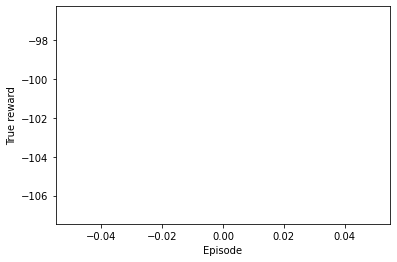

In [15]:
test(render=True, total_episodes=1)